# Table of Contents
 <p><div class="lev1"><a href="#Derive-scaling"><span class="toc-item-num">1&nbsp;&nbsp;</span>Derive scaling</a></div><div class="lev2"><a href="#Compute-statistics"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Compute statistics</a></div><div class="lev3"><a href="#1D-PDFs"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>1D PDFs</a></div><div class="lev3"><a href="#2D-PDFs"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>2D PDFs</a></div><div class="lev3"><a href="#Decompose-bias-into-its-contributions-from-qvstar-and-omega-(scaling-#3)"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Decompose bias into its contributions from qvstar and omega (scaling #3)</a></div><div class="lev2"><a href="#Decompose-the-variance"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Decompose the variance</a></div><div class="lev3"><a href="#Decompose-Variance-into-its-contributions-from-qvstar-and-omega-(scaling-#3)"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Decompose Variance into its contributions from qvstar and omega (scaling #3)</a></div><div class="lev3"><a href="#Decompose-variance-into-its-contributions-from-T-and-omega-(ignore-variability-in-pressure)"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Decompose variance into its contributions from T and omega (ignore variability in pressure)</a></div><div class="lev1"><a href="#Save-all-variables-in-dataframe"><span class="toc-item-num">2&nbsp;&nbsp;</span>Save all variables in dataframe</a></div>

In [1]:
%load_ext autoreload
%matplotlib inline

In [37]:
%autoreload 2

print("-- loading modules")
print()

import numpy as np
import numpy.ma as ma
import dask.array as da
import matplotlib
# matplotlib.use("PDF")
import matplotlib.pyplot as plt
import datetime as dt
import time
import sys,os,glob
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LogNorm

## Add own library to path
workdir = os.getcwd()
thismodule = sys.modules[__name__]
moduledir = os.path.join(os.path.dirname(workdir),'functions')
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])

## Load own libraries
from environmentAndDirectories import *
from importingData import *
from scalingApproximations import *
from slicingAndSubsetting import *
from thermoConstants import L_v,R_v
from plotMaps import *
from plot1DInvLog import *
from plot2D import *
from statisticalDistributions import *
from outputResults import *

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

-- loading modules

Own modules available: ['plot1DInvLog', 'thermoFunctions', 'statisticalDistributions', 'slicingAndSubsetting', 'plot2D', 'outputResults', 'thermoConstants', 'plotMaps', 'daskOptions', 'scalingApproximations', 'CAMsettings', 'environmentAndDirectories', 'importingData', 'physicalConstants']


In [7]:
print()
print("-- define global variables")
print()

print("- choosing options:")
compset = 'FSPCAMm_AMIP'
experiment = 'piControl'
member = 'r1i1p1'
subset = 'tropics'
time_stride = '1d'
resolution = '1dx'
daskarray = False
tracktime = True
dates = ('185005010100','185005020000')

for v in ['compset','experiment','member','subset','time_stride','resolution',\
          'daskarray','dates']:
    print("%s:"%v,getattr(thismodule,v))

# Figure output directory
figdir = os.path.join(os.path.dirname(workdir),'figures','omega500tsps',compset,experiment,member,subset,\
                      time_stride,resolution)
os.makedirs(figdir,exist_ok=True)

# Results output directory
resultdir = os.path.join(os.path.dirname(workdir),'results','omega500tsps',compset,experiment,member,subset,\
                      time_stride,resolution)
os.makedirs(resultdir,exist_ok=True)

print()


-- define global variables

- choosing options:
compset: FSPCAMm_AMIP
experiment: piControl
member: r1i1p1
subset: tropics
time_stride: 1d
resolution: 1dx
daskarray: False
dates: ('185005010100', '185005020000')



In [8]:
if tracktime:
    t0 = time.time()

In [9]:
print("-- load environment and variables")
print()

historyFilesSettings = getCAMHistoryFilesSettings()
handle = 'h0'
inputdir, inputdir_processed_day, inputdir_processed_1hr, inputdir_results, inputdir_fx = \
    getInputDirectories(compset,experiment)

omega_id = 'OMEGA'
omega = getValues(omega_id,compset,subset,experiment,time_stride,resolution,daskarray=daskarray,dates=dates,handle=handle)
pr_id = 'PRECT'
pr = getValues(pr_id,compset,subset,experiment,time_stride,resolution,daskarray=daskarray,dates=dates,handle=handle)
pr *= rho_l    # convert from m/s to kg/m2/s
ts_id = 'TS'
ts = getValues(ts_id,compset,subset,experiment,time_stride,resolution,daskarray=daskarray,dates=dates,handle=handle)
ta_id = 'T'
ta = getValues(ta_id,compset,subset,experiment,time_stride,resolution,daskarray=daskarray,dates=dates,handle=handle)
relhum_id = 'RELHUM'
relhum = getValues(relhum_id,compset,subset,experiment,time_stride,resolution,daskarray=daskarray,dates=dates,handle=handle)


-- load environment and variables

Importing OMEGA from 24 history files between 1850-05-01-03600 and 1850-05-02-00000
Importing PRECT from 24 history files between 1850-05-01-03600 and 1850-05-02-00000
Importing TS from 24 history files between 1850-05-01-03600 and 1850-05-02-00000
Importing T from 24 history files between 1850-05-01-03600 and 1850-05-02-00000
Importing RELHUM from 24 history files between 1850-05-01-03600 and 1850-05-02-00000


In [10]:
## Get longitude, latitude and landmask

print("- load geographic data")

fh = Dataset(os.path.join(inputdir_fx,'landmask_fx_CESM111-SPCAM20_allExperiments_r0i0p0.nc'))
lon1D = fh.variables['lon'][:]
lat1D = fh.variables['lat'][:]
lon2D, lat2D = np.meshgrid(lon1D,lat1D)
lon2D = da.from_array(lon2D,chunks=lon2D.shape)
lat2D = da.from_array(lat2D,chunks=lat2D.shape)

landmask = fh.variables['landmask']
fh.close()


- load geographic data


In [11]:
print("- load surface pressure")

input_lev_file = os.path.join(inputdir_fx,'lev_fx_CESM111-SPCAM20_allExperiments_r0i0p0.nc')
computeP = getPressureCoordinateFunction(input_lev_file)

ps_varid = 'PS'
ps = getValues(ps_varid,compset,subset,experiment,time_stride,resolution,daskarray=daskarray,dates=dates,handle=handle)
pres = computeP(ps)
cn = getArrayType(pres)


- load surface pressure
Importing PS from 24 history files between 1850-05-01-03600 and 1850-05-02-00000


# Derive scaling

In [12]:
print()
print("-- compute (percentile-wise and pointwise) scaling approximation")
print()


-- compute (percentile-wise and pointwise) scaling approximation



In [13]:
%%time
print("compute 2D surfaces of predictor variables")
p_500 = 50000; levdim=1
omega_500 = isobaricSurface(omega,pres,p_ref=p_500,levdim=levdim)
qvstar_s = saturationSpecificHumidity(ts,ps)

compute 2D surfaces of predictor variables
CPU times: user 37 ms, sys: 7.27 ms, total: 44.2 ms
Wall time: 47 ms


In [14]:
%%time
print("Compute ranks and ranks locations")

n_pts = pr.size
Q_IL = getInvLogRanks(n_pts,n_pts_per_bin=1,fill_last_decade=True)
i_Q = indexOfRank(99.9,Q_IL)
iQ_slice = slice(i_Q-5,i_Q+5)
ranks, centers, bins = computePercentilesAndBinsFromRanks(pr.flatten(),Q_IL)
iQ_min = 8
iQ_max = min(len(Q_IL),41)
# iQ_max = min(len(Q_IL),iQ_slice.stop)

# Define reference percentiles and compute percentiles
targetranks = Q_IL[iQ_min:iQ_max]
ranks_ref = Q_IL[:iQ_max]
percentiles = adjustRanks(centers,ranks,ranks_ref)

# Suffix to save figures and results
output_suffix = 'Q%d-Q%d_%s'%(iQ_min,iQ_max,'-'.join(dates))

rank_locations= {}
for rank in ranks_ref:
    rank_id  = "%2.4f"%rank
    print(rank_id,end=' ')
    rank_locations[rank_id] = getRankLocations(rank,pr,ranks,bins,rank_locations)
print()

Compute ranks and ranks locations
0.0000 20.5672 36.9043 49.8813 60.1893 68.3772 74.8811 80.0474 84.1511 87.4107 90.0000 92.0567 93.6904 94.9881 96.0189 96.8377 97.4881 98.0047 98.4151 98.7411 99.0000 99.2057 99.3690 99.4988 99.6019 99.6838 99.7488 99.8005 99.8415 99.8741 99.9000 99.9206 99.9369 99.9499 99.9602 99.9684 99.9749 99.9800 99.9842 99.9874 99.9900 
CPU times: user 13.7 ms, sys: 1.45 ms, total: 15.1 ms
Wall time: 82 ms


In [15]:
print("compute sample size in each bin")
N_prQ = sampleSizeAtAllRanks(targetranks,pr,ranks_ref,rank_locations=rank_locations)
print(np.nansum(N_prQ),pr.size)

compute sample size in each bin
1025.0 4608


> Plot sample size in each percentile bin


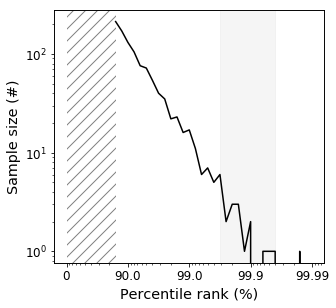

In [16]:
print("> Plot sample size in each percentile bin")

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))

ax.set_yscale('log')

# Add zero line
addZeroLine(ax,ranks_ref)

# Grey shading 
i_Q_lims = (iQ_slice.start, iQ_slice.stop-1)
subplotXShadingRanksILog(ax,ranks_ref,i_Q_lims,alpha=0.15,transformX=False)

subplotRanksILog(ax,ranks_ref,
                 N_prQ,
                 col='k',ltype='-',transformX=False)

addXHatchRanksILog(ax,ranks_ref,(0,iQ_min),transformX=True)

ax.set_xlabel('Percentile rank (%)')
ax.set_ylabel('Sample size (#)')

plt.savefig(os.path.join(figdir,'sample_size_in_P_bins_%s.pdf'%output_suffix),
            bbox_inches='tight')

plt.show()

In [17]:
%%time
print("compute pointwise scaling")
eps, pr_sc_vQ = computeScalingOmegaQAtAllRanks(targetranks,omega_500,qvstar_s,pr,ranks_ref=ranks_ref[iQ_slice],
                                               percentiles_ref=percentiles[iQ_slice],
                                               bins=bins,rank_locations=rank_locations)
pr_sc_vQ = adjustRanks(pr_sc_vQ,targetranks,ranks_ref)
pr_sc = singleLevelScalingFromOmegaQ(omega_500,qvstar_s,efficiency=eps)
print("eps =",eps)

compute pointwise scaling
eps = 0.573237600929
CPU times: user 11.2 ms, sys: 2.81 ms, total: 14 ms
Wall time: 17.8 ms


In [18]:
%%time
print("compute O'Gorman&Schneider scaling with environmental temperature profile")
eps_OGS09, pr_scOGS09_vQ = computeScalingOGS09AtAllRanks(targetranks,omega,ta,pres,pr,
    ranks_ref=ranks_ref[iQ_slice],percentiles_ref=percentiles[iQ_slice],bins=bins,
                                                         rank_locations=rank_locations)
pr_scOGS09_vQ = adjustRanks(pr_scOGS09_vQ,targetranks,ranks_ref)
pr_scOGS09 = scalingOGS09(omega,ta,pres,efficiency=eps_OGS09,levdim=1)
print("eps_OGS09 =",eps_OGS09)

compute O'Gorman&Schneider scaling with environmental temperature profile
eps_OGS09 = 0.968063552826
CPU times: user 265 ms, sys: 0 ns, total: 265 ms
Wall time: 263 ms


In [19]:
%%time
print("compute O'Gorman&Schneider scaling with moist adiabat")
# Get temperature values at lowest level
levdim = 1
nlev = pres.shape[levdim]
i_bottom = bottomIndex(np.moveaxis(pres,levdim,-1).ravel()[-nlev:])
ta_bottom = np.take(ta,axis=levdim,indices=i_bottom)
# Compute scaling
eps_OGS09ad, pr_scOGS09ad_vQ = computeScalingOGS09AtAllRanks(targetranks,omega,ta_bottom,pres,pr,
    temp_type='adiabat',relhum=relhum,ranks_ref=ranks_ref[iQ_slice],percentiles_ref=percentiles[iQ_slice],bins=bins,
                                                         rank_locations=rank_locations)
pr_scOGS09ad_vQ = adjustRanks(pr_scOGS09ad_vQ,targetranks,ranks_ref)
pr_scOGS09ad = scalingOGS09(omega,ta_bottom,pres,temp_type='adiabat',relhum=relhum,efficiency=eps_OGS09ad,levdim=1)
print("eps_OGS09ad =",eps_OGS09ad)

compute O'Gorman&Schneider scaling with moist adiabat
eps_OGS09ad = 0.968984709019
CPU times: user 456 ms, sys: 0 ns, total: 456 ms
Wall time: 455 ms


In [20]:
%%time
print("compute extended O'Gorman&Schneider scaling with environmental temperature profile")
fracarea_boost, entrainment, pr_scRH_vQ = computeScalingRHAtAllRanks(targetranks,omega,ta,pres,relhum,pr,
    ranks_ref=ranks_ref[iQ_slice],bins=bins,rank_locations=rank_locations)
pr_scRH_vQ = adjustRanks(pr_scRH_vQ,targetranks,ranks_ref)
pr_scRH = scalingRH(omega,ta,pres,relhum,fracarea_boost=fracarea_boost,entrainment=entrainment,levdim=1)
print(pr_scRH.shape)
print("fracarea_boost =",fracarea_boost)
print("entrainment =",entrainment)

compute extended O'Gorman&Schneider scaling with environmental temperature profile
(1, 32, 144)
fracarea_boost = 1.11849335294
entrainment = 0.000440100176532
CPU times: user 375 ms, sys: 0 ns, total: 375 ms
Wall time: 412 ms


In [21]:
%%time
print("compute extended O'Gorman&Schneider scaling with moist adiabat")
# Get temperature values at lowest level
levdim = 1
nlev = pres.shape[levdim]
i_bottom = bottomIndex(np.moveaxis(pres,levdim,-1).ravel()[-nlev:])
ta_bottom = np.take(ta,axis=levdim,indices=i_bottom)
# Compute scaling
fracarea_boost_ad, entrainment_ad, pr_scRHad_vQ = computeScalingRHAtAllRanks(targetranks,omega,ta_bottom,pres,relhum,pr,
    temp_type='adiabat',ranks_ref=ranks_ref[iQ_slice],bins=bins,rank_locations=rank_locations)
pr_scRHad_vQ = adjustRanks(pr_scRHad_vQ,targetranks,ranks_ref)
pr_scRHad = scalingRH(omega,ta_bottom,pres,relhum,fracarea_boost=fracarea_boost_ad,entrainment=entrainment_ad,
                    temp_type='adiabat',levdim=1)
print(pr_scRHad.shape)
print("fracarea_boost =",fracarea_boost_ad)
print("entrainment =",entrainment_ad)

compute extended O'Gorman&Schneider scaling with moist adiabat
(1, 32, 144)
fracarea_boost = 1.20422440295
entrainment = 0.000631000113461
CPU times: user 538 ms, sys: 0 ns, total: 538 ms
Wall time: 538 ms


## Compute statistics

### 1D PDFs

In [22]:
print()
print("-- compute statistics")
print()


-- compute statistics



In [23]:
# %%time
print("mean of scalings in pr bins")
pr_sc_prQ = meanXAtAllYRanks(targetranks,pr_sc,pr,ranks_ref,rank_locations=rank_locations)
pr_scOGS09_prQ = meanXAtAllYRanks(targetranks,pr_scOGS09,pr,ranks_ref,rank_locations=rank_locations)
pr_scOGS09ad_prQ = meanXAtAllYRanks(targetranks,pr_scOGS09ad,pr,ranks_ref,rank_locations=rank_locations)
pr_scRH_prQ = meanXAtAllYRanks(targetranks,pr_scRH,pr,ranks_ref,rank_locations=rank_locations)
pr_scRHad_prQ = meanXAtAllYRanks(targetranks,pr_scRHad,pr,ranks_ref,rank_locations=rank_locations)

mean of scalings in pr bins


In [24]:
%%time
print("interquartile and 90% ranges")
ranks_I90 = (5,95)
ranks_IQR = (25,75)

pr_sc_I90 = XPercentilesAtAllYRanks(targetranks,pr_sc,ranks_I90,pr,ranks_ref,rank_locations_X=rank_locations)
pr_sc_IQR = XPercentilesAtAllYRanks(targetranks,pr_sc,ranks_IQR,pr,ranks_ref,rank_locations_X=rank_locations)

pr_scOGS09_I90 = XPercentilesAtAllYRanks(targetranks,pr_scOGS09,ranks_I90,pr,ranks_ref,rank_locations_X=rank_locations)
pr_scOGS09_IQR = XPercentilesAtAllYRanks(targetranks,pr_scOGS09,ranks_IQR,pr,ranks_ref,rank_locations_X=rank_locations)

pr_scOGS09ad_I90 = XPercentilesAtAllYRanks(targetranks,pr_scOGS09ad,ranks_I90,pr,ranks_ref,rank_locations_X=rank_locations)
pr_scOGS09ad_IQR = XPercentilesAtAllYRanks(targetranks,pr_scOGS09ad,ranks_IQR,pr,ranks_ref,rank_locations_X=rank_locations)

pr_scRH_I90 = XPercentilesAtAllYRanks(targetranks,pr_scRH,ranks_I90,pr,ranks_ref,rank_locations_X=rank_locations)
pr_scRH_IQR = XPercentilesAtAllYRanks(targetranks,pr_scRH,ranks_IQR,pr,ranks_ref,rank_locations_X=rank_locations)

pr_scRHad_I90 = XPercentilesAtAllYRanks(targetranks,pr_scRHad,ranks_I90,pr,ranks_ref,rank_locations_X=rank_locations)
pr_scRHad_IQR = XPercentilesAtAllYRanks(targetranks,pr_scRHad,ranks_IQR,pr,ranks_ref,rank_locations_X=rank_locations)


interquartile and 90% ranges
CPU times: user 51 ms, sys: 0 ns, total: 51 ms
Wall time: 51.9 ms


> plot PDF with scaling and variability
- scaling sc


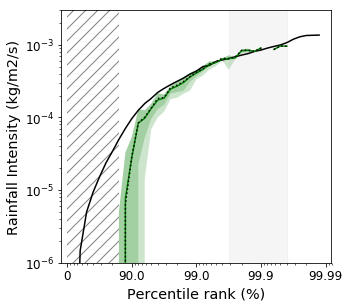

- scaling scOGS09


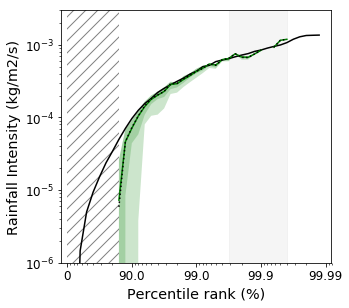

- scaling scOGS09ad


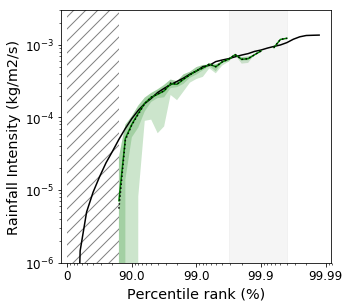

- scaling scRH


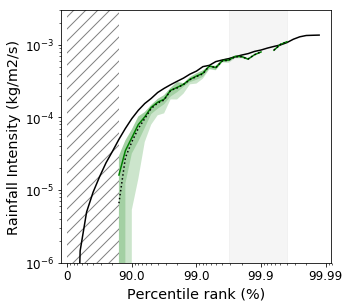

- scaling scRHad


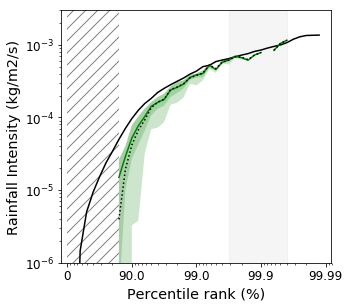

In [25]:
print("> plot PDF with scaling and variability")

scaling_names = 'sc','scOGS09','scOGS09ad','scRH','scRHad'

for sc_name in scaling_names:

    print("- scaling %s"%sc_name)

    for suffix in 'prQ','vQ','IQR','I90':
        setattr(thismodule,'var_%s'%suffix,getattr(thismodule,'pr_%s_%s'%(sc_name,suffix)))
    
    fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))

    ax.set_yscale('log')
    ax.set_ylim((1e-6,3e-3))

    # Grey shading 
    i_Q_lims = (iQ_slice.start, iQ_slice.stop-1)
    subplotXShadingRanksILog(ax,ranks_ref,i_Q_lims,alpha=0.15,transformX=False)
    # 90% confidence interval for pointwise scaling 2
    subplotYShadingRanksILog(ax,ranks_ref,[var_I90[:,0],var_IQR[:,1]],col='green',transformX=False)
    # Interquartile range for pointwise scaling 2
    subplotYShadingRanksILog(ax,ranks_ref,[var_IQR[:,0],var_IQR[:,1]],col='green',transformX=False)
    # Mean of pointwise scaling 2
    subplotRanksILog(ax,ranks_ref,[percentiles,var_prQ,var_vQ],col=['k','green','k'],ltype=['-','-',':'],\
                     transformX=False)

    addXHatchRanksILog(ax,ranks_ref,(0,iQ_min),transformX=True)

    ax.set_xlabel('Percentile rank (%)')
    ax.set_ylabel('Rainfall Intensity (kg/m2/s)')
    # ax.set_title(r'$\varepsilon\omega_{500}q_v^\star(T)$')

    plt.savefig(os.path.join(figdir,'pdf_P_and_P%s_mean_IQR_I90_%s.pdf'%(sc_name,output_suffix)),
                bbox_inches='tight')

    plt.show()

### 2D PDFs

In [56]:
%%time
print("compute 2D PDFs")

all_pr_varnames = set({'pr','pr_sc','pr_scOGS09','pr_scOGS09ad','pr_scRH','pr_scRHad'})

for varname1 in all_pr_varnames:
    for varname2 in all_pr_varnames.difference(varname1):

        var1 = getattr(thismodule,varname1)
        var2 = getattr(thismodule,varname2)

        sample1 = var1.flatten()
        sample2 = var2.flatten()
        mode1 = 'invlogQ'
        mode2 = 'invlogQ'

        ranks1, percentiles1, bins1, ranks2, percentiles2, bins2, density2D =\
            compute2dDensities(sample1,sample2,mode1,mode2)

        density2D = adjust2dOnRanks(density2D,ranks1,ranks2,ranks_ref,ranks_ref)
        bins1 = adjustBinsOnRanks(bins1,ranks1,ranks_ref)
        bins2 = adjustBinsOnRanks(bins2,ranks2,ranks_ref)
        percentiles1 = adjustRanks(percentiles1,ranks1,ranks_ref)
        percentiles2 = adjustRanks(percentiles2,ranks2,ranks_ref)
        ranks1 = ranks_ref.copy()
        ranks2 = ranks_ref.copy()
            
        setattr(thismodule,"density2D_%s_%s"%(varname1,varname2),density2D)

        N1 = sampleSizeAtAllRanks(ranks1,var1,ranks_ref,rank_locations=rank_locations)
        N2 = sampleSizeAtAllRanks(ranks2,var2,ranks_ref,bins=bins2)
        norm_factor = normalize2dDensity(N1,N2,n_pts)

        norm_density2D = density2D/norm_factor
        setattr(thismodule,"norm_density2D_%s_%s"%(varname1,varname2),norm_density2D)

compute 2D PDFs
CPU times: user 1.88 s, sys: 10.8 ms, total: 1.89 s
Wall time: 1.88 s


> plot 2D PDFs
- pr_scRH vs. pr_scRH
41 1681


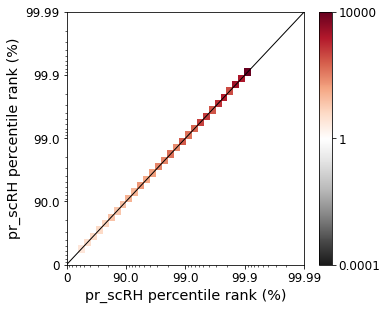

- pr_scOGS09 vs. pr_scRH
41 1681


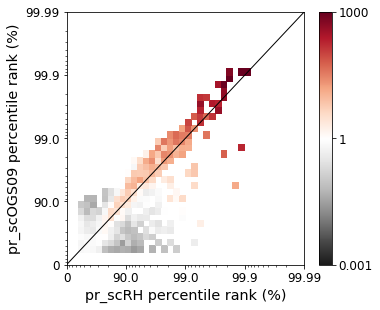

- pr_scOGS09ad vs. pr_scRH
41 1681


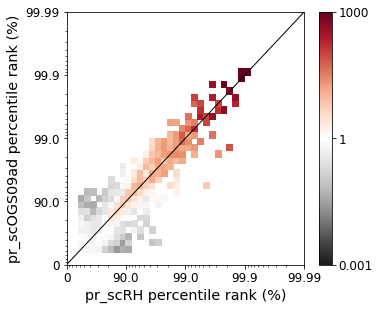

- pr_sc vs. pr_scRH
41 1681


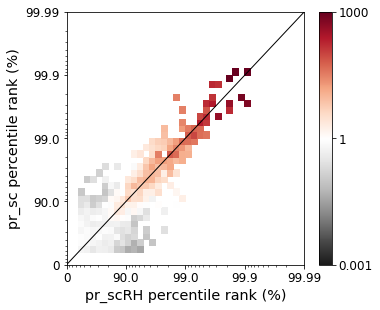

- pr_scRHad vs. pr_scRH
41 1681


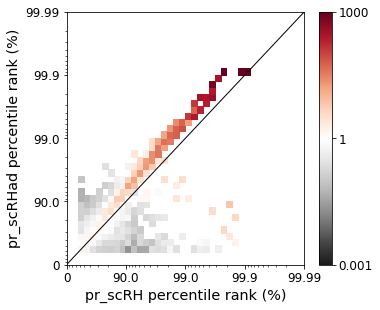

- pr vs. pr_scRH
41 1681


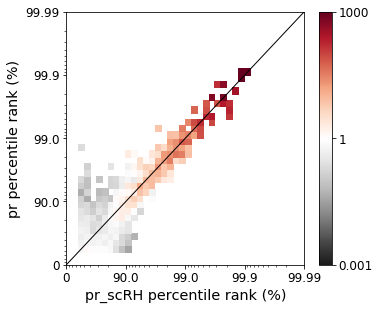

- pr_scRH vs. pr_scOGS09
41 1681


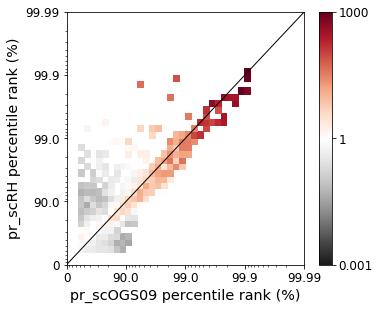

- pr_scOGS09 vs. pr_scOGS09
41 1681


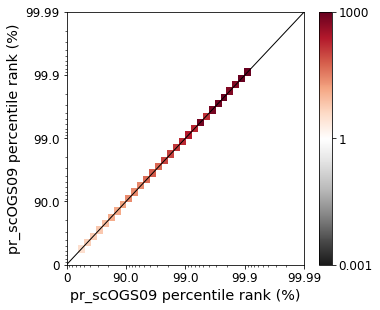

- pr_scOGS09ad vs. pr_scOGS09
41 1681


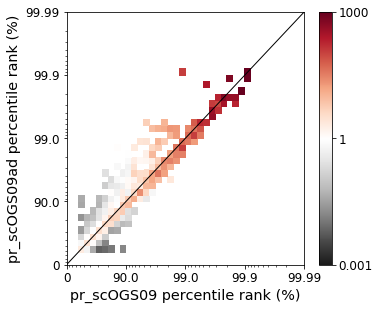

- pr_sc vs. pr_scOGS09
41 1681


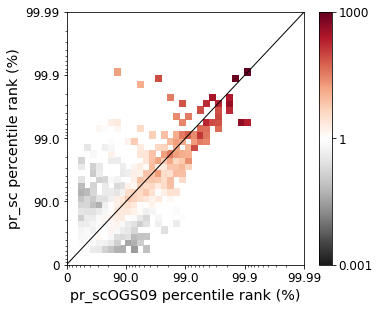

- pr_scRHad vs. pr_scOGS09
41 1681


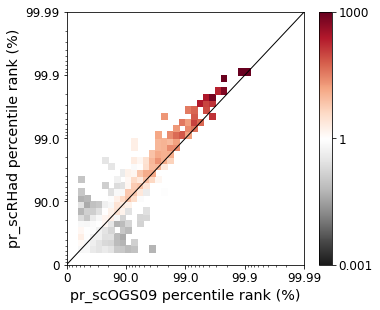

- pr vs. pr_scOGS09
41 1681


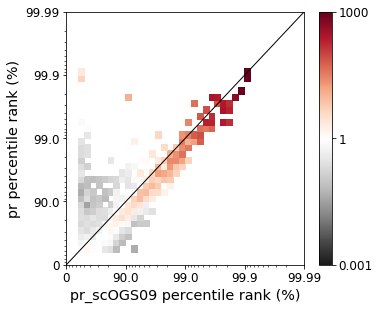

- pr_scRH vs. pr_scOGS09ad
41 1681


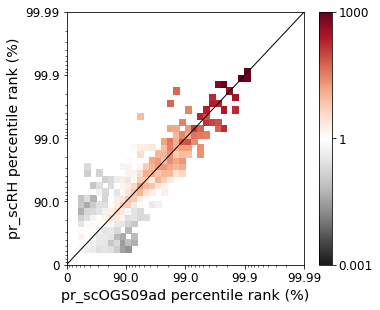

- pr_scOGS09 vs. pr_scOGS09ad
41 1681


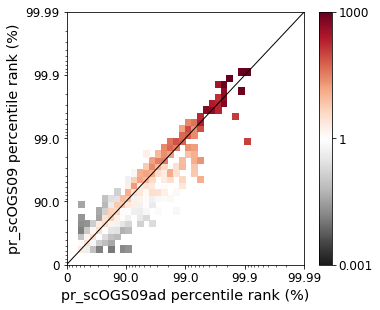

- pr_scOGS09ad vs. pr_scOGS09ad
41 1681


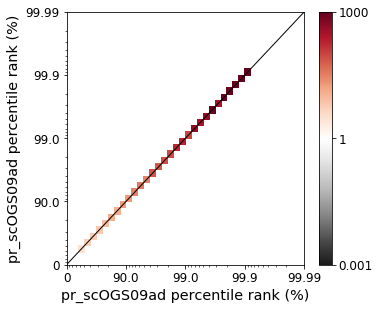

- pr_sc vs. pr_scOGS09ad
41 1681


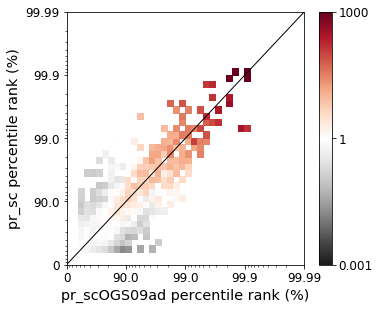

- pr_scRHad vs. pr_scOGS09ad
41 1681


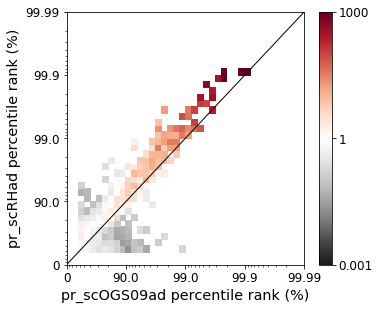

- pr vs. pr_scOGS09ad
41 1681


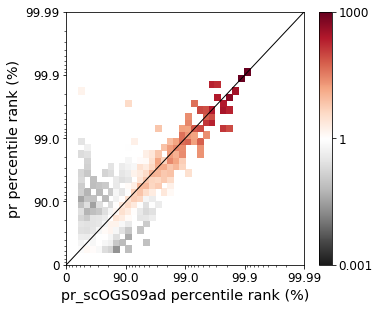

- pr_scRH vs. pr_sc
41 1681


KeyboardInterrupt: 

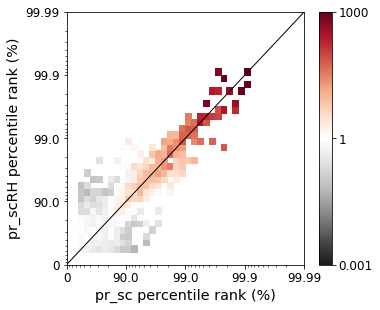

In [74]:
print("> plot 2D PDFs")

plotAll2dPDFs = True

if plotAll2dPDFs:
    
    for varname1 in all_pr_varnames:
        for varname2 in all_pr_varnames:
            
            print("- %s vs. %s"%(varname2,varname1))

            norm_density2D = getattr(thismodule,"norm_density2D_%s_%s"%(varname1,varname2))

            fig, ax = plt.subplots(figsize=(5.5,4.5))

            # cmap = plt.cm.RdBu_r
            cmap = plt.cm.RdGy_r
            # cmap = plt.cm.RdYlBu_r
            # cmap = plt.cm.PRGn
            
            subplot2DRanksILog(ax,ranks_ref,ranks_ref,norm_density2D,cmap=cmap,
                transformX=True,transformY=True)

            add1to1Line(ax)

            ax.set_xlabel('%s percentile rank (%%)'%varname1)
            ax.set_ylabel('%s percentile rank (%%)'%varname2)

            plt.savefig(os.path.join(figdir,'pdf2D_%s_and_%s_%s.pdf'%(varname1,varname2,output_suffix)),
                            bbox_inches='tight')
            plt.show()

### Decompose bias into its contributions from qvstar and omega (scaling #3)

In [75]:
print()
print("-- decompose bias into qvstar and omega contributions")
print()


-- decompose bias into qvstar and omega contributions



In [76]:
%%time
print("Q-mean terms")
qvstar_s_prQ = meanXAtAllYRanks(targetranks,qvstar_s,pr,ranks_ref,rank_locations=rank_locations)
omega_500_prQ = meanXAtAllYRanks(targetranks,omega_500,pr,ranks_ref,rank_locations=rank_locations)

Q-mean terms
CPU times: user 6.62 ms, sys: 3.81 ms, total: 10.4 ms
Wall time: 8.92 ms


In [77]:
%%time
print("Compute bias")
bias_sc = (pr_sc_prQ - pr_sc_vQ)/pr_sc_prQ
bias_scOGS09 = (pr_scOGS09_prQ - pr_scOGS09_vQ)/pr_scOGS09_prQ
bias_scOGS09ad = (pr_scOGS09ad_prQ - pr_scOGS09ad_vQ)/pr_scOGS09ad_prQ
bias_scRH = (pr_scRH_prQ - pr_scRH_vQ)/pr_scRH_prQ
bias_scRHad = (pr_scRHad_prQ - pr_scRHad_vQ)/pr_scRHad_prQ
print("single-level scaling:",np.nanmean(bias_sc[iQ_slice]))
print("OGS09 scaling:",np.nanmean(bias_scOGS09[iQ_slice]))
print("OGS09ad scaling:",np.nanmean(bias_scOGS09ad[iQ_slice]))
print("RH scaling:",np.nanmean(bias_scRH[iQ_slice]))
print("RHad scaling:",np.nanmean(bias_scRHad[iQ_slice]))

Compute bias
single-level scaling: -0.00395769083432
OGS09 scaling: 0.000650615470531
OGS09ad scaling: -0.000114127852439
RH scaling: 0.0014040454329
RHad scaling: -0.00148138928013
CPU times: user 3.55 ms, sys: 0 ns, total: 3.55 ms
Wall time: 3.69 ms


In [78]:
%%time
print("covariance term")
cov_qvstar_s_omega_500_prQ = covAtAllYRanks(targetranks,qvstar_s,omega_500,pr,ranks_ref,
                                            rank_locations=rank_locations)

covariance term
CPU times: user 8.99 ms, sys: 143 µs, total: 9.14 ms
Wall time: 19 ms


In [79]:
print("normalized contribution")
contribQOmega_bias_covQOmega = cov_qvstar_s_omega_500_prQ/qvstar_s_prQ/omega_500_prQ

normalized contribution


> plot bias and corresponding contributions


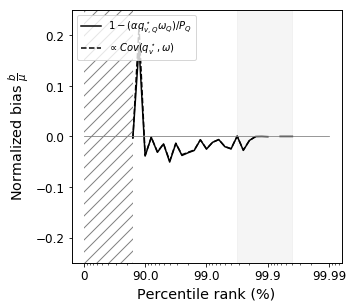

CPU times: user 1.34 s, sys: 110 ms, total: 1.45 s
Wall time: 1.46 s


In [80]:
%%time
print("> plot bias and corresponding contributions")

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))
ax.set_ylim((-.25,.25))

# Grey shading 
i_Q_lims = (iQ_slice.start, iQ_slice.stop-1)
subplotXShadingRanksILog(ax,ranks_ref,i_Q_lims,alpha=0.15,transformX=False)

# zero line
addZeroLine(ax,ranks_ref)

subplotRanksILog(ax,ranks_ref,
                 bias_sc,
                 col='k',ltype='-',transformX=False)

subplotRanksILog(ax,ranks_ref,
                 contribQOmega_bias_covQOmega,
                 col='k',ltype='--',transformX=False)

addXHatchRanksILog(ax,ranks_ref,(0,iQ_min),transformX=True)

ax.legend([r'$1-(\alpha q_{v,Q}^\star \omega_Q) / P_Q$',r'$\propto Cov(q_v^\star,\omega)$'],
          loc = 'upper left')

ax.set_xlabel('Percentile rank (%)')
ax.set_ylabel(r'Normalized bias $\frac{b}{\mu}$')

plt.savefig(os.path.join(figdir,'bias_and_cov_omega_q_%s.pdf'%output_suffix),
            bbox_inches='tight')

plt.show()

> plot bias for OGS09 scaling
- scaling scOGS09
- scaling scOGS09ad
- scaling scRH
- scaling scRHad


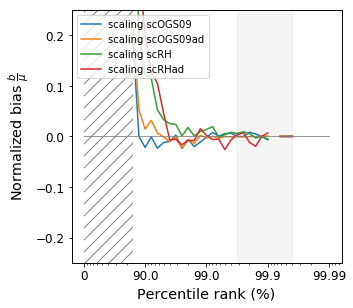

CPU times: user 912 ms, sys: 66.9 ms, total: 978 ms
Wall time: 990 ms


In [84]:
%%time
print("> plot bias for OGS09 scaling")

scaling_names = 'scOGS09','scOGS09ad','scRH','scRHad'

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))
ax.set_ylim((-.25,.25))

# Grey shading 
i_Q_lims = (iQ_slice.start, iQ_slice.stop-1)
subplotXShadingRanksILog(ax,ranks_ref,i_Q_lims,alpha=0.15,transformX=False)

# zero line
addZeroLine(ax,ranks_ref)

for sc_name in scaling_names:

    print("- scaling %s"%sc_name)

    setattr(thismodule,'bias',getattr(thismodule,'bias_%s'%(sc_name)))
    
    subplotRanksILog(ax,ranks_ref,
                     bias,
                     ltype='-',transformX=False)

addXHatchRanksILog(ax,ranks_ref,(0,iQ_min),transformX=True)
    
ax.legend([r'scaling %s'%sc_name for sc_name in scaling_names],
          loc = 'upper left')

ax.set_xlabel('Percentile rank (%)')
ax.set_ylabel(r'Normalized bias $\frac{b}{\mu}$')

plt.savefig(os.path.join(figdir,'bias_%s_%s.pdf'%('_'.join(scaling_names),output_suffix)),
            bbox_inches='tight')

plt.show()

## Decompose the variance

### Decompose Variance into its contributions from qvstar and omega (scaling #3)

In [85]:
print()
print("-- decompose variance into qvstar and omega contributions")
print()


-- decompose variance into qvstar and omega contributions



In [86]:
%%time 
print("Compute the variance in pr")
scaling_names = 'sc','scOGS09','scOGS09ad','scRH','scRHad'

for sc_name in scaling_names:
    var_pr = varXAtAllYRanks(targetranks,
                            getattr(thismodule,'pr_%s'%sc_name),
                            pr,ranks_ref,rank_locations=rank_locations)
    setattr(thismodule,'var_pr_%s_prQ'%sc_name,var_pr)

Compute the variance in pr
CPU times: user 24.4 ms, sys: 0 ns, total: 24.4 ms
Wall time: 24.3 ms


In [87]:
print("normalized variability")
for sc_name in scaling_names:
    norm_var_pr = getattr(thismodule,'var_pr_%s_prQ'%sc_name)/getattr(thismodule,'pr_%s_prQ'%sc_name)**2
    setattr(thismodule,'norm_var_pr_%s_prQ'%sc_name,norm_var_pr)
    print("scaling %s:"%sc_name,np.nanmean(norm_var_pr[iQ_slice]))

normalized variability
scaling sc: 0.0112271514736
scaling scOGS09: 0.00336240560501
scaling scOGS09ad: 0.00602134799627
scaling scRH: 0.00286725003308
scaling scRHad: 0.00345884669278


In [88]:
%%time
print("compute variability terms")
var_qvstar_s_prQ = varXAtAllYRanks(targetranks,qvstar_s,pr,ranks_ref,rank_locations=rank_locations)
var_omega_500_prQ = varXAtAllYRanks(targetranks,omega_500,pr,ranks_ref,rank_locations=rank_locations)
cov_qvstar_s_omega_500_prQ = covAtAllYRanks(targetranks,qvstar_s,omega_500,pr,ranks_ref,
                                            rank_locations=rank_locations)
cov_qvstar_s_2_omega_500_2_prQ = covAtAllYRanks(targetranks,qvstar_s**2,omega_500**2,pr,ranks_ref,
                                                rank_locations=rank_locations)

compute variability terms
CPU times: user 21 ms, sys: 124 µs, total: 21.1 ms
Wall time: 19.5 ms


In [89]:
print("normalized contributions, expanded terms")

# a_v = (eps/gg)**2
# contrib_covX2Y2 = a_v*cov_qvstar_s_2_omega_500_2_prQ/(pr_sc_prQ**2)
# contrib_varX = a_v*(omega_500_prQ**2)*var_qvstar_s_prQ/(pr_sc_prQ**2)
# contrib_varY = a_v*(qvstar_s_prQ**2)*var_omega_500_prQ/(pr_sc_prQ**2)
# contrib_varXvarY = a_v*var_qvstar_s_prQ*var_omega_500_prQ/(pr_sc_prQ**2)
# contrib_cov2XY = -a_v*(cov_qvstar_s_omega_500_prQ**2)/(pr_sc_prQ**2)
# contrib_covXY = -a_v*2*qvstar_s_prQ*omega_500_prQ*cov_qvstar_s_omega_500_prQ/(pr_sc_prQ**2)
contribQOmega_var_covQ2Omega2 = cov_qvstar_s_2_omega_500_2_prQ/((omega_500_prQ*qvstar_s_prQ)**2)
contribQOmega_var_varQ = var_qvstar_s_prQ/(qvstar_s_prQ**2)
contribQOmega_var_varOmega = var_omega_500_prQ/(omega_500_prQ**2)
contribQOmega_var_varQvarOmega = var_qvstar_s_prQ*var_omega_500_prQ/((omega_500_prQ*qvstar_s_prQ)**2)
contribQOmega_var_cov2QOmega = -(cov_qvstar_s_omega_500_prQ**2)/((omega_500_prQ*qvstar_s_prQ)**2)
contribQOmega_var_covQOmega = -2*cov_qvstar_s_omega_500_prQ/(omega_500_prQ*qvstar_s_prQ)
contribQOmega_var_sum = contribQOmega_var_covQ2Omega2 + contribQOmega_var_varQ + contribQOmega_var_varOmega + \
    contribQOmega_var_varQvarOmega + contribQOmega_var_cov2QOmega + contribQOmega_var_covQOmega

print(np.nanmean(contribQOmega_var_covQ2Omega2[iQ_slice]),np.nanmean(contribQOmega_var_varQ[iQ_slice]),
      np.nanmean(contribQOmega_var_varOmega[iQ_slice]),np.nanmean(contribQOmega_var_varQvarOmega[iQ_slice]),
      np.nanmean(contribQOmega_var_cov2QOmega[iQ_slice]),np.nanmean(contribQOmega_var_covQOmega[iQ_slice]),
      np.nanmean(contribQOmega_var_sum[iQ_slice]))

normalized contributions, expanded terms
-0.0277393459826 0.0125177277472 0.0124527068951 0.000183334669237 -0.000156472854557 0.0139265990269 0.0111845495012


> plot variance and corresponding contributions


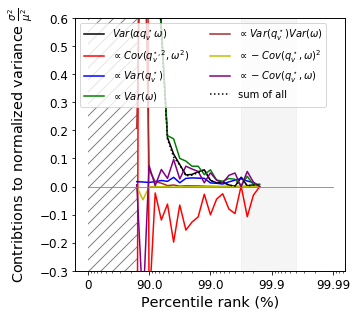

CPU times: user 1.78 s, sys: 102 ms, total: 1.88 s
Wall time: 1.89 s


In [90]:
%%time
print("> plot variance and corresponding contributions")

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))
ax.set_ylim((-.3,.6))

# Grey shading 
i_Q_lims = (iQ_slice.start, iQ_slice.stop-1)
subplotXShadingRanksILog(ax,ranks_ref,i_Q_lims,alpha=0.15,transformX=False)

# zero line
addZeroLine(ax,ranks_ref)

subplotRanksILog(ax,ranks_ref,
                 norm_var_pr_sc_prQ,
                 col='k',ltype='-',transformX=False)
subplotRanksILog(ax,ranks_ref,
                 [contribQOmega_var_covQ2Omega2,contribQOmega_var_varQ,contribQOmega_var_varOmega,
                  contribQOmega_var_varQvarOmega,contribQOmega_var_cov2QOmega,contribQOmega_var_covQOmega,
                  contribQOmega_var_sum],
                 col=['r','b','g','brown','y','purple','k'],ltype=['-','-','-','-','-','-',':'],transformX=False)

addXHatchRanksILog(ax,ranks_ref,(0,iQ_min),transformX=True)

leg = ax.legend([r'$Var(\alpha q_v^\star \omega)$',
                 r'$\propto Cov(q_v^{\star,2},\omega^2)$',
                 r'$\propto Var(q_v^\star)$',
                 r'$\propto Var(\omega)$',
                 r'$\propto Var(q_v^\star)Var(\omega)$',
                 r'$\propto -Cov(q_v^\star,\omega)^2$',
                 r'$\propto -Cov(q_v^\star,\omega)$',
                 r'sum of all'],
                 loc='upper left',
                 framealpha=0.8,
                 ncol=2)

ax.set_xlabel('Percentile rank (%)')
ax.set_ylabel(r'Contribtions to normalized variance $\frac{\sigma^2}{\mu^2}$')

plt.savefig(os.path.join(figdir,'var_and_contributions_omega_q_%s.pdf'%output_suffix),
            bbox_inches='tight')

plt.show()

> plot variance for vertical scalings
- add scaling scOGS09
- add scaling scOGS09ad
- add scaling scRH
- add scaling scRHad


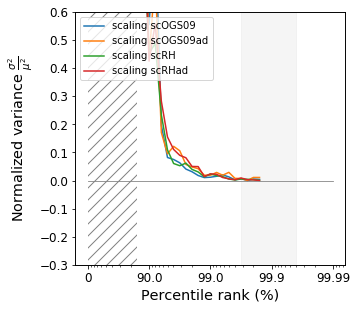

CPU times: user 1.08 s, sys: 58.9 ms, total: 1.14 s
Wall time: 1.14 s


In [91]:
%%time
print("> plot variance for vertical scalings")

scaling_names = 'scOGS09','scOGS09ad','scRH','scRHad'


fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))
ax.set_ylim((-.3,.6))

# Grey shading 
i_Q_lims = (iQ_slice.start, iQ_slice.stop-1)
subplotXShadingRanksILog(ax,ranks_ref,i_Q_lims,alpha=0.15,transformX=False)

# zero line
addZeroLine(ax,ranks_ref)
    
for sc_name in scaling_names:

    print("- add scaling %s"%sc_name)
    setattr(thismodule,'norm_var',getattr(thismodule,'norm_var_pr_%s_prQ'%(sc_name)))

    subplotRanksILog(ax,ranks_ref,
                     norm_var,
                     ltype='-',transformX=False)

addXHatchRanksILog(ax,ranks_ref,(0,iQ_min),transformX=True)

leg = ax.legend([r'scaling %s'%sc_name for sc_name in scaling_names],
                 loc='upper left',
                 framealpha=0.8)

ax.set_xlabel('Percentile rank (%)')
ax.set_ylabel(r'Normalized variance $\frac{\sigma^2}{\mu^2}$')

plt.savefig(os.path.join(figdir,'var_%s_%s.pdf'%('_'.join(scaling_names),output_suffix)),
            bbox_inches='tight')

plt.show()

### Decompose variance into its contributions from T and omega (ignore variability in pressure)

In [92]:
print()
print("-- decompose variance into T and omega contributions")
print()


-- decompose variance into T and omega contributions



In [93]:
print("Q-mean terms")
ts_prQ = meanXAtAllYRanks(targetranks,ts,pr,ranks_ref,rank_locations=rank_locations)

Q-mean terms


In [94]:
%%time
print("compute variability terms")
var_ts_prQ = varXAtAllYRanks(targetranks,ts,pr,ranks_ref,rank_locations=rank_locations)
cov_ts_omega_500_prQ = covAtAllYRanks(targetranks,ts,omega_500,pr,ranks_ref,rank_locations=rank_locations)
cov_ts_omega_500_2_prQ = covAtAllYRanks(targetranks,ts,omega_500**2,pr,ranks_ref,rank_locations=rank_locations)

compute variability terms
CPU times: user 17.4 ms, sys: 0 ns, total: 17.4 ms
Wall time: 18.4 ms


In [95]:
print("normalized contributions, expanded terms")

contribTOmega_var_covTOmega2 = 2*L_v/R_v*cov_ts_omega_500_2_prQ/(ts_prQ*omega_500_prQ)**2
contribTOmega_var_covTOmega = -2*L_v/R_v*cov_ts_omega_500_prQ/((ts_prQ**2)*omega_500_prQ)
contribTOmega_var_varT = ((L_v/R_v)**2)*var_ts_prQ/(ts_prQ**4)
contribTOmega_var_varOmega = var_omega_500_prQ/(omega_500_prQ**2)
contribTOmega_var_sum = contribTOmega_var_covTOmega2+contribTOmega_var_covTOmega+contribTOmega_var_varT+\
    contribTOmega_var_varOmega
all_contribTOmega_var = [contribTOmega_var_covTOmega2,contribTOmega_var_covTOmega,contribTOmega_var_varT,
                    contribTOmega_var_varOmega,contribTOmega_var_sum]
for contrib in all_contribTOmega_var:
    print(np.nanmean(contrib[iQ_slice]),end=' ')
print()

normalized contributions, expanded terms
-0.0260326772061 0.0131290022351 0.0133319871082 0.0124527068951 0.0128810190324 


> plot variance and corresponding contributions


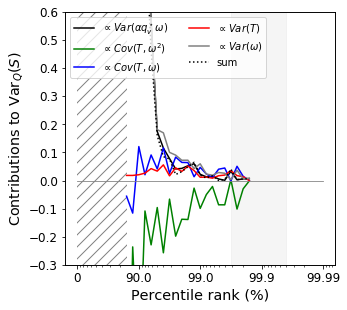

CPU times: user 1.42 s, sys: 70.6 ms, total: 1.49 s
Wall time: 1.49 s


In [96]:
%%time 
print("> plot variance and corresponding contributions")

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))

ax.set_ylim((-0.3,0.6))

# Grey shading 
i_Q_lims = (iQ_slice.start, iQ_slice.stop-1)
subplotXShadingRanksILog(ax,ranks_ref,i_Q_lims,alpha=0.15,transformX=False)

# zero line
addZeroLine(ax,ranks_ref)

# subplotRanksILog(ax,ranks,np.zeros(ranks.shape),ltype=':',col='k')
subplotRanksILog(ax,ranks_ref,
                 norm_var_pr_sc_prQ,
                 col='k',ltype='-',transformX=False)

subplotRanksILog(ax,ranks_ref,
                 all_contribTOmega_var,
                 col=['green','blue','red','grey','k'],ltype=['-','-','-','-',':'],transformX=False)

addXHatchRanksILog(ax,ranks_ref,(0,iQ_min),transformX=True)

ax.set_xlabel('Percentile rank (%)')
ax.set_ylabel(r'Contributions to Var$_Q(S)$')
# ax.set_title(r'$S(\omega,T)=\varepsilon\omega_{500}q_v^\star(T)$')

ax.legend([r'$\propto Var(\alpha q_v^\star \omega)$',r'$\propto Cov(T,\omega^2)$',r'$\propto Cov(T,\omega)$',
           r'$\propto Var(T)$',
           r'$\propto Var(\omega)$','sum'],ncol=2,framealpha=0.8,loc='upper left')

plt.savefig(os.path.join(figdir,'var_and_contributions_omega_T_%s.pdf'%output_suffix),
            bbox_inches='tight')

plt.show()

# Save all variables in dataframe

In [97]:
print("-- Save results")
import pandas as pd
import re
import pickle

-- Save results


In [98]:
print("find all varnames to save")
vars_out = ['ranks_ref','percentiles']
vars_out.extend([v for v in locals().keys() if v.endswith('prQ') or v.endswith('vQ')])
vars_out.extend([v for v in locals().keys() if v.startswith('contrib')])

find all varnames to save


In [111]:
print("create result dataframe")
results_df = pd.DataFrame({v:getattr(thismodule,v) for v in vars_out})

create result dataframe


In [112]:
resultfile = 'results_%s.csv'%output_suffix
print("> save results to %s"%resultfile)
results_df.to_csv(os.path.join(resultdir,resultfile))
print()

> save results to results_Q8-Q41_185005010000-185005020000.csv



In [113]:
if tracktime:
    timingfile = 'timing.csv'
    fulltimingfile = os.path.join(resultdir,timingfile)
    t1 = time.time()
    time_elapsed_s = t1-t0
    timing_df = saveTiming(fulltimingfile,output_suffix,pr.size,time_elapsed_s,reset_value=True)

Script successfully terminated in 1:33:15.747368.
> Save timing and size info to /Users/bfildier/Code/researchProjects/dataAnalysis/extremeRainPredictabilityAcrossScales/results/omega500tsps/FSPCAMm_AMIP/piControl/r1i1p1/tropics/6hrs/3dx/timing.csv.
